In [1]:
# ✅ Bloc 1 : Installation et Importation des librairies
# ============================================================
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow nonconformist ta

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for nonconformist: filename=nonconformist-2.1.0-py3-none-any.whl size=17817 sha256=3f348a370bd9f8f801770cb793daff7bfcffcd335c271f209443fa8cdf1a17ca
  Stored in directory: /root/.cache/pip/wheels/04/27/ff/b8e84bf0a1e9713e59c0be2be9986e3f0f1c9593529acbeca9
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=aa1f1238e504a5262669c2578625dbdadb244473bee3a452227295e412ea325c
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built nonconformist ta


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import time

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Conformal Prediction
from nonconformist.base import RegressorAdapter
from nonconformist.nc import RegressorNc, AbsErrorErrFunc
from nonconformist.cp import IcpRegressor
from nonconformist.icp import IcpRegressor as IcpReg

# Technical Analysis
from ta import trend, momentum, volatility, volume, others

print("✅ Toutes les librairies sont importées")
print(f"TensorFlow version: {tf.__version__}")

✅ Toutes les librairies sont importées
TensorFlow version: 2.19.0


In [3]:
# ✅ Bloc 2 : Téléchargement des données avec yfinance
# ============================================================
def download_stock_data(symbol="BTC-USD", period="2y", interval="1h"):
    """
    Télécharge les données historiques depuis Yahoo Finance
    """
    print(f"📥 Téléchargement des données pour {symbol}...")

    ticker = yf.Ticker(symbol)
    df = ticker.history(period=period, interval=interval)

    # Nettoyage des données
    df.index = pd.to_datetime(df.index)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.columns = ['open', 'high', 'low', 'close', 'volume']

    print(f"📊 Données téléchargées : {df.shape}")
    print(f"📅 Période : {df.index[0]} au {df.index[-1]}")
    print(f"📈 Prix de clôture : {df['close'].iloc[-1]:.2f}")

    return df

# Choix du symbole (vous pouvez changer)
SYMBOL = "BTC-USD"  # Apple, mais vous pouvez mettre "MSFT", "GOOGL", "BTC-USD", etc.
df = download_stock_data(SYMBOL, period="1y", interval="1h")

# Affichage des premières et dernières lignes
print("\n📋 Aperçu des données :")
print(df.head())
print("\n📊 Statistiques descriptives :")
print(df.describe())


📥 Téléchargement des données pour BTC-USD...
📊 Données téléchargées : (8603, 5)
📅 Période : 2025-01-25 01:00:00+00:00 au 2026-01-25 01:00:00+00:00
📈 Prix de clôture : 89166.07

📋 Aperçu des données :
                                    open           high            low  \
Datetime                                                                 
2025-01-25 01:00:00+00:00  104416.640625  104784.351562  104404.437500   
2025-01-25 02:00:00+00:00  104619.921875  104755.875000  104476.695312   
2025-01-25 03:00:00+00:00  104517.281250  105169.000000  104455.070312   
2025-01-25 04:00:00+00:00  105142.843750  105142.843750  104621.523438   
2025-01-25 05:00:00+00:00  104604.257812  104649.070312  104280.695312   

                                   close  volume  
Datetime                                          
2025-01-25 01:00:00+00:00  104719.085938       0  
2025-01-25 02:00:00+00:00  104501.382812       0  
2025-01-25 03:00:00+00:00  105169.000000       0  
2025-01-25 04:00:00+00:00 

In [4]:
# ✅ Bloc 3 : Feature Engineering Avancé
# ============================================================
def create_advanced_features(df, window_sizes=[5, 10, 20, 50, 100]):
    """
    Crée des features techniques avancés pour le modèle LSTM
    """
    df = df.copy()

    # 1. Retours
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['returns_5'] = df['close'].pct_change(5)
    df['returns_10'] = df['close'].pct_change(10)

    # 2. Moyennes mobiles
    for window in window_sizes:
        df[f'MA_{window}'] = df['close'].rolling(window).mean()
        df[f'EMA_{window}'] = df['close'].ewm(span=window, adjust=False).mean()
        df[f'MA_ratio_{window}'] = df['close'] / df[f'MA_{window}']

    # 3. RSI (Relative Strength Index)
    df['rsi'] = momentum.rsi(df['close'], window=14)
    df['rsi_7'] = momentum.rsi(df['close'], window=7)

    # 4. MACD
    macd = trend.MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = df['macd'] - df['macd_signal']
    df['macd_histogram'] = trend.macd_diff(df['close'])

    # 5. Bollinger Bands
    df['bb_high'] = volatility.bollinger_hband(df['close'], window=20)
    df['bb_low'] = volatility.bollinger_lband(df['close'], window=20)
    df['bb_mid'] = volatility.bollinger_mavg(df['close'], window=20)
    df['bb_width'] = (df['bb_high'] - df['bb_low']) / df['bb_mid']
    df['bb_percentage'] = (df['close'] - df['bb_low']) / (df['bb_high'] - df['bb_low'])

    # 6. ATR (Average True Range)
    df['atr'] = volatility.average_true_range(df['high'], df['low'], df['close'], window=14)
    df['atr_percentage'] = df['atr'] / df['close']

    # 7. Volume Indicators
    df['volume_ma'] = df['volume'].rolling(20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma']
    df['obv'] = volume.on_balance_volume(df['close'], df['volume'])
    df['volume_price_trend'] = volume.volume_price_trend(df['close'], df['volume'])

    # 8. Momentum Indicators
    df['stoch_k'] = momentum.stoch(df['high'], df['low'], df['close'], window=14)
    df['stoch_d'] = momentum.stoch_signal(df['high'], df['low'], df['close'], window=14)
    df['williams_r'] = momentum.williams_r(df['high'], df['low'], df['close'], lbp=14)
    # Correction: Awesome Oscillator est directement une fonction dans ta.momentum
    df['awesome_oscillator'] = momentum.awesome_oscillator(high=df['high'], low=df['low'], window1=5, window2=34)

    # 9. Volatility
    df['daily_volatility'] = df['log_returns'].rolling(20).std()
    df['annualized_volatility'] = df['daily_volatility'] * np.sqrt(252)

    # 10. Support & Resistance Levels
    df['rolling_high_20'] = df['high'].rolling(20).max()
    df['rolling_low_20'] = df['low'].rolling(20).min()
    df['distance_to_high'] = (df['rolling_high_20'] - df['close']) / df['close']
    df['distance_to_low'] = (df['close'] - df['rolling_low_20']) / df['close']

    # 11. Price Patterns
    df['high_low_ratio'] = df['high'] / df['low']
    df['close_open_ratio'] = df['close'] / df['open']
    df['body_size'] = np.abs(df['close'] - df['open'])
    df['upper_shadow'] = df['high'] - df[['close', 'open']].max(axis=1)
    df['lower_shadow'] = df[['close', 'open']].min(axis=1) - df['low']

    # 12. Lag Features (pour séries temporelles)
    for lag in [1, 2, 3, 5, 10]:
        df[f'close_lag_{lag}'] = df['close'].shift(lag)
        df[f'volume_lag_{lag}'] = df['volume'].shift(lag)
        df[f'returns_lag_{lag}'] = df['returns'].shift(lag)

    # 13. Rolling Statistics
    df['rolling_std_10'] = df['close'].rolling(10).std()
    df['rolling_skew_10'] = df['close'].rolling(10).skew()
    df['rolling_kurt_10'] = df['close'].rolling(10).kurt()

    # 14. Time Features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    # 15. Market Regime Features
    df['trend_strength'] = np.abs(df['close'] - df['MA_20']) / df['atr']
    df['volatility_regime'] = pd.qcut(df['annualized_volatility'], 4, labels=False)

    # Target variable (prédiction 1 à 5 périodes dans le futur)
    for horizon in [1, 3, 5]:
        df[f'target_{horizon}'] = df['close'].shift(-horizon)
        df[f'returns_future_{horizon}'] = (df['close'].shift(-horizon) - df['close']) / df['close']

    # Suppression des NaN
    df = df.dropna()

    print(f"✅ Features créés : {df.shape[1]} colonnes au total")
    print(f"📅 Nombre de périodes : {df.shape[0]}")

    return df

# Application du feature engineering
df_features = create_advanced_features(df)
print("\n📋 Colonnes disponibles après feature engineering :")
print(df_features.columns.tolist())

✅ Features créés : 86 colonnes au total
📅 Nombre de périodes : 8426

📋 Colonnes disponibles après feature engineering :
['open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns', 'returns_5', 'returns_10', 'MA_5', 'EMA_5', 'MA_ratio_5', 'MA_10', 'EMA_10', 'MA_ratio_10', 'MA_20', 'EMA_20', 'MA_ratio_20', 'MA_50', 'EMA_50', 'MA_ratio_50', 'MA_100', 'EMA_100', 'MA_ratio_100', 'rsi', 'rsi_7', 'macd', 'macd_signal', 'macd_diff', 'macd_histogram', 'bb_high', 'bb_low', 'bb_mid', 'bb_width', 'bb_percentage', 'atr', 'atr_percentage', 'volume_ma', 'volume_ratio', 'obv', 'volume_price_trend', 'stoch_k', 'stoch_d', 'williams_r', 'awesome_oscillator', 'daily_volatility', 'annualized_volatility', 'rolling_high_20', 'rolling_low_20', 'distance_to_high', 'distance_to_low', 'high_low_ratio', 'close_open_ratio', 'body_size', 'upper_shadow', 'lower_shadow', 'close_lag_1', 'volume_lag_1', 'returns_lag_1', 'close_lag_2', 'volume_lag_2', 'returns_lag_2', 'close_lag_3', 'volume_lag_3', 'returns_lag

In [5]:
# ✅ Bloc 4 : Préparation des séquences pour LSTM
# ============================================================
def prepare_lstm_sequences(df, target_col='target_1', sequence_length=60, test_size=0.2):
    """
    Prépare les séquences pour le modèle LSTM
    """
    # Sélection des features (exclure les targets futures)
    exclude_cols = [col for col in df.columns if 'target_' in col or 'returns_future_' in col]
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    print(f"🔤 Nombre de features : {len(feature_cols)}")
    print(f"📊 Longueur des séquences : {sequence_length}")

    # Extraction des features et target
    features = df[feature_cols].values
    target = df[target_col].values

    # Normalisation
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    features_scaled = scaler_X.fit_transform(features)
    target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))

    # Création des séquences
    X, y = [], []
    for i in range(len(features_scaled) - sequence_length):
        X.append(features_scaled[i:i+sequence_length])
        y.append(target_scaled[i+sequence_length])

    X = np.array(X)
    y = np.array(y)

    print(f"📊 Forme des données : X={X.shape}, y={y.shape}")

    # Split train/val/test
    train_size = int(0.7 * len(X))
    cal_size = int(0.15 * len(X))

    X_train = X[:train_size]
    y_train = y[:train_size]

    X_cal = X[train_size:train_size+cal_size]
    y_cal = y[train_size:train_size+cal_size]

    X_test = X[train_size+cal_size:]
    y_test = y[train_size+cal_size:]

    print(f"✅ Split des données :")
    print(f"   Train : {X_train.shape[0]} séquences")
    print(f"   Calibration : {X_cal.shape[0]} séquences")
    print(f"   Test : {X_test.shape[0]} séquences")

    return (X_train, y_train, X_cal, y_cal, X_test, y_test,
            scaler_X, scaler_y, feature_cols)

# Préparation des données
sequence_length = 60
(X_train, y_train, X_cal, y_cal, X_test, y_test,
 scaler_X, scaler_y, feature_cols) = prepare_lstm_sequences(df_features, sequence_length=sequence_length)


🔤 Nombre de features : 80
📊 Longueur des séquences : 60
📊 Forme des données : X=(8366, 60, 80), y=(8366, 1)
✅ Split des données :
   Train : 5856 séquences
   Calibration : 1254 séquences
   Test : 1256 séquences


In [6]:
# ✅ Bloc 5 : Construction du modèle LSTM avancé
# ============================================================
def build_advanced_lstm(input_shape, units=100, dropout_rate=0.3, l2_reg=0.001):
    """
    Construit un modèle LSTM avancé avec plusieurs couches
    """
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(units, return_sequences=True,
                          kernel_regularizer=l2(l2_reg),
                          recurrent_regularizer=l2(l2_reg))),
        Dropout(dropout_rate),

        LSTM(units//2, return_sequences=True,
            kernel_regularizer=l2(l2_reg),
            recurrent_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),

        LSTM(units//4, return_sequences=False,
            kernel_regularizer=l2(l2_reg),
            recurrent_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),

        Dense(50, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate/2),

        Dense(25, activation='relu', kernel_regularizer=l2(l2_reg)),

        Dense(1)
    ])

    # Compilation avec learning rate adaptatif
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model

# Construction et affichage du modèle
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = build_advanced_lstm(input_shape)

print("🧠 Architecture du modèle LSTM :")
lstm_model.summary()


🧠 Architecture du modèle LSTM :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 200)        │       144,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,201 (801.57 KB)

 Trainable params: 205,201 (801.57 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ✅ Bloc 6 : Entraînement du modèle avec callbacks
# ============================================================
# Callbacks pour améliorer l'entraînement
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Entraînement du modèle
print("🚀 Début de l'entraînement du LSTM...")
history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    shuffle=False  # Important pour les séries temporelles
)

print(f"✅ Entraînement terminé après {len(history.history['loss'])} époques")


🚀 Début de l'entraînement du LSTM...
Epoch 1/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.7888 - mae: 0.2940 - mse: 0.1477 - val_loss: 0.4070 - val_mae: 0.2223 - val_mse: 0.0715 - learning_rate: 0.0010
Epoch 2/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.4401 - mae: 0.2737 - mse: 0.1348 - val_loss: 0.2978 - val_mae: 0.1984 - val_mse: 0.0551 - learning_rate: 0.0010
Epoch 3/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.3811 - mae: 0.3010 - mse: 0.1501 - val_loss: 0.2706 - val_mae: 0.2061 - val_mse: 0.0612 - learning_rate: 0.0010
Epoch 4/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.3750 - mae: 0.3217 - mse: 0.1708 - val_loss: 0.2428 - val_mae: 0.2081 - val_mse: 0.0607 - learning_rate: 0.0010
Epoch 5/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.3693 - mae: 0.3493 - mse: 0.1936 - val_loss: 0.2183 - val_mae: 0.2061 - val_mse: 0.0603 - learning_rate: 0.0010
Epoch 6/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.3192 - mae: 0.3213

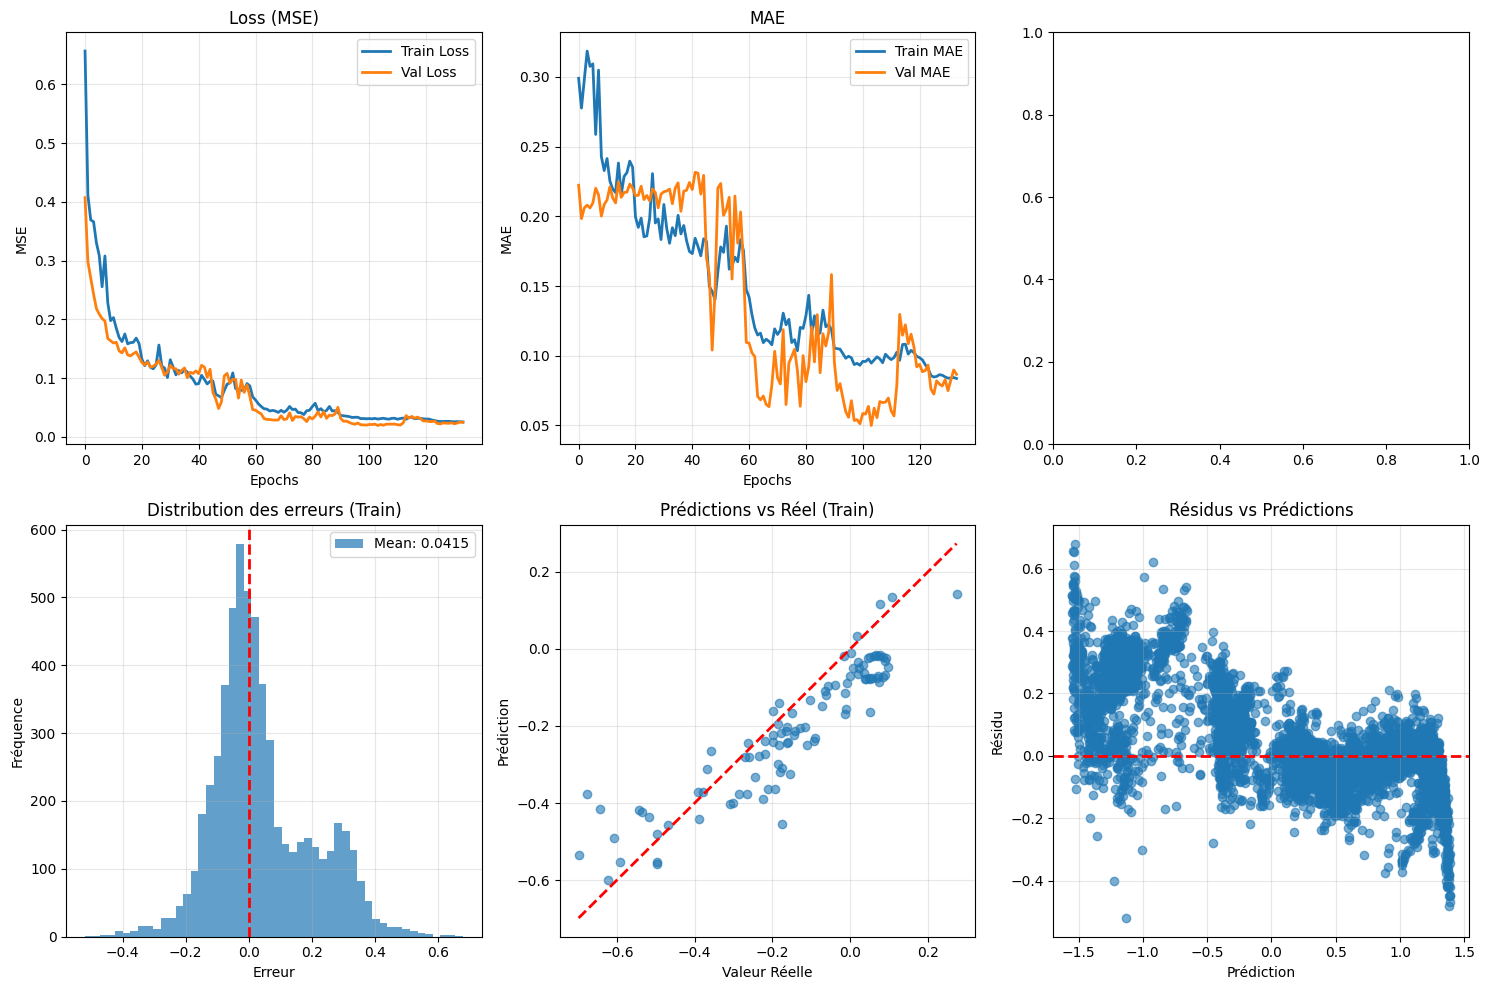

In [8]:
# ✅ Bloc 7 : Visualisation des résultats d'entraînement
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Loss (MSE)')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE
axes[0, 1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[0, 1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
axes[0, 1].set_title('MAE')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning Rate
if 'lr' in history.history:
    axes[0, 2].plot(history.history['lr'], label='Learning Rate', color='purple', linewidth=2)
    axes[0, 2].set_title('Learning Rate')
    axes[0, 2].set_xlabel('Epochs')
    axes[0, 2].set_ylabel('LR')
    axes[0, 2].set_yscale('log')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

# Histogramme des erreurs
train_pred = lstm_model.predict(X_train, verbose=0).flatten()
train_errors = train_pred - y_train.flatten()
axes[1, 0].hist(train_errors, bins=50, alpha=0.7, label=f'Mean: {np.mean(train_errors):.4f}')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('Distribution des erreurs (Train)')
axes[1, 0].set_xlabel('Erreur')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Prédictions vs Réel (échantillon)
sample_size = min(100, len(X_train))
sample_pred = train_pred[:sample_size]
sample_real = y_train[:sample_size].flatten()
axes[1, 1].scatter(sample_real, sample_pred, alpha=0.6)
axes[1, 1].plot([sample_real.min(), sample_real.max()],
                [sample_real.min(), sample_real.max()],
                'r--', linewidth=2)
axes[1, 1].set_title('Prédictions vs Réel (Train)')
axes[1, 1].set_xlabel('Valeur Réelle')
axes[1, 1].set_ylabel('Prédiction')
axes[1, 1].grid(True, alpha=0.3)

# Résidus
axes[1, 2].scatter(train_pred, train_errors, alpha=0.6)
axes[1, 2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 2].set_title('Résidus vs Prédictions')
axes[1, 2].set_xlabel('Prédiction')
axes[1, 2].set_ylabel('Résidu')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
# ✅ Bloc 8 : Conformal Prediction pour LSTM
# ============================================================
class LSTMWrapperConformal:
    """
    Wrapper pour adapter le modèle LSTM à nonconformist
    """
    def __init__(self, lstm_model, scaler_y):
        self.model = lstm_model
        self.scaler_y = scaler_y
        self.is_fitted = True  # Le modèle est déjà entraîné

    def fit(self, X, y):
        # Le modèle LSTM est déjà entraîné, on retourne juste self
        return self

    def predict(self, X):
        """
        Prédiction avec le modèle LSTM
        X doit avoir la forme (n_samples, sequence_length, n_features)
        """
        if len(X.shape) == 2:
            # Si X est flatten, on le reshape
            n_features = len(feature_cols)
            X = X.reshape(-1, sequence_length, n_features)

        # Prédiction
        pred_scaled = self.model.predict(X, verbose=0)

        # Transformation inverse
        return self.scaler_y.inverse_transform(pred_scaled)

# Initialisation du wrapper
lstm_wrapper = LSTMWrapperConformal(lstm_model, scaler_y)

# Création du modèle conforme avec fonction d'erreur absolue
nc_model = RegressorAdapter(lstm_wrapper)
nc = RegressorNc(nc_model, AbsErrorErrFunc())

# Initialisation du prédicteur conforme
icp = IcpRegressor(nc)

# Pour la calibration, on doit flatten X_cal
X_cal_flat = X_cal.reshape(X_cal.shape[0], -1)
y_cal_original = scaler_y.inverse_transform(y_cal).flatten()

# Fit et calibration
print("🔧 Calibration du modèle conforme...")
icp.fit(X_cal_flat, y_cal_original)
icp.calibrate(X_cal_flat, y_cal_original)

print("✅ Modèle conforme calibré avec succès")


🔧 Calibration du modèle conforme...
✅ Modèle conforme calibré avec succès


In [10]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from nonconformist.cp import IcpRegressor
from nonconformist.nc import AbsErrorErrFunc, RegressorNc

# ============================================================
# 1. Création d'un Adaptateur pour le modèle LSTM
# ============================================================
class KerasLSTMAdapter(BaseEstimator, RegressorMixin):
    def __init__(self, model, input_shape):
        self.model = model
        self.input_shape = input_shape  # (timesteps, features)

    def fit(self, X, y):
        # Le modèle est déjà entraîné, on ne fait rien ici
        return self

    def predict(self, X):
        # 1. On remet X en 3D pour le LSTM : (N, timesteps, features)
        X_3d = X.reshape((X.shape[0], self.input_shape[0], self.input_shape[1]))

        # 2. Prédiction du modèle
        preds = self.model.predict(X_3d, verbose=0)

        # 3. CRUCIAL : On aplatit la sortie pour nonconformist (N, 1) -> (N,)
        return preds.flatten()

# ============================================================
# 2. Re-Calibration (Nécessaire pour corriger l'erreur)
# ============================================================
# Récupération des dimensions depuis vos données
timesteps = X_train.shape[1]
features = X_train.shape[2]

# Création de l'adaptateur
lstm_adapter = KerasLSTMAdapter(lstm_model, input_shape=(timesteps, features))

# Configuration de la prédiction conforme
nc = RegressorNc(lstm_adapter, err_func=AbsErrorErrFunc())
icp = IcpRegressor(nc)

# Préparation des données de calibration (Aplatir X et y !)
# Note : On utilise X_cal et y_cal définis précédemment dans votre code
X_cal_flat = X_cal.reshape(X_cal.shape[0], -1)
y_cal_flat = y_cal.flatten()  # Force le vecteur 1D

# Calibration
print("⏳ Recalibration en cours...")
icp.fit(X_cal_flat, y_cal_flat)
icp.calibrate(X_cal_flat, y_cal_flat)
print("✅ Calibration terminée.")

# ============================================================
# 3. Prédictions Conformes (Votre Bloc 9 corrigé)
# ============================================================
def get_conformal_predictions(icp, X, significance=0.1, scaler_y=None):
    """
    Obtient les prédictions avec intervalles de confiance conformes
    """
    # Flatten de X pour l'entrée de l'adaptateur
    X_flat = X.reshape(X.shape[0], -1)

    # Prédictions conformes (bornes)
    intervals = icp.predict(X_flat, significance=significance)

    # Pour la prédiction ponctuelle, on utilise le milieu de l'intervalle
    # ou on appelle l'adaptateur directement.
    # Ici, l'adaptateur renvoie déjà les données scalées.
    pred_scaled_flat = lstm_adapter.predict(X_flat)

    # Inverse transform pour revenir à l'échelle réelle
    point_preds = scaler_y.inverse_transform(pred_scaled_flat.reshape(-1, 1)).flatten()

    # Inverse transform des intervalles (borne inf et sup)
    intervals_real = scaler_y.inverse_transform(intervals)

    return point_preds, intervals_real

# Exécution
significance_levels = [0.01, 0.05, 0.1] # Ajout des niveaux de signification manquants
results = {}

# Données de test (Aplaties pour le wrapper)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_test_original = scaler_y.inverse_transform(y_test).flatten()

for alpha in significance_levels:
    print(f"\n🔍 Niveau de signification : {alpha*100}% (Intervalle de confiance : {100*(1-alpha)}%)")

    try:
        point_preds, intervals = get_conformal_predictions(
            icp, X_test, significance=alpha, scaler_y=scaler_y
        )

        # Métriques
        errors = point_preds - y_test_original
        mae = np.mean(np.abs(errors))
        rmse = np.sqrt(np.mean(errors**2))

        # Couverture
        coverage = np.mean((y_test_original >= intervals[:, 0]) & (y_test_original <= intervals[:, 1]))
        avg_width = np.mean(intervals[:, 1] - intervals[:, 0])
        avg_width_pct = avg_width / np.mean(y_test_original) * 100

        results[alpha] = {
            'mae': mae, 'rmse': rmse, 'coverage': coverage,
            'avg_width': avg_width, 'intervals': intervals,
            'point_preds': point_preds, 'errors': errors,
            'avg_width_pct': avg_width_pct
        }

        print(f"   MAE: {mae:.4f}")
        print(f"   RMSE: {rmse:.4f}")
        print(f"   Couverture: {coverage:.2%} (cible: {1-alpha:.0%})")
        print(f"   Largeur moyenne: {avg_width:.4f} ({avg_width_pct:.2f}% du prix)")

    except Exception as e:
        print(f"❌ Erreur lors de la prédiction pour alpha={alpha}: {e}")

⏳ Recalibration en cours...
✅ Calibration terminée.

🔍 Niveau de signification : 1.0% (Intervalle de confiance : 99.0%)
   MAE: 2073.4672
   RMSE: 2428.0312
   Couverture: 100.00% (cible: 99%)
   Largeur moyenne: 14368.9639 (15.91% du prix)

🔍 Niveau de signification : 5.0% (Intervalle de confiance : 95.0%)
   MAE: 2073.4672
   RMSE: 2428.0312
   Couverture: 99.60% (cible: 95%)
   Largeur moyenne: 10954.8176 (12.13% du prix)

🔍 Niveau de signification : 10.0% (Intervalle de confiance : 90.0%)
   MAE: 2073.4672
   RMSE: 2428.0312
   Couverture: 95.70% (cible: 90%)
   Largeur moyenne: 8687.3014 (9.62% du prix)


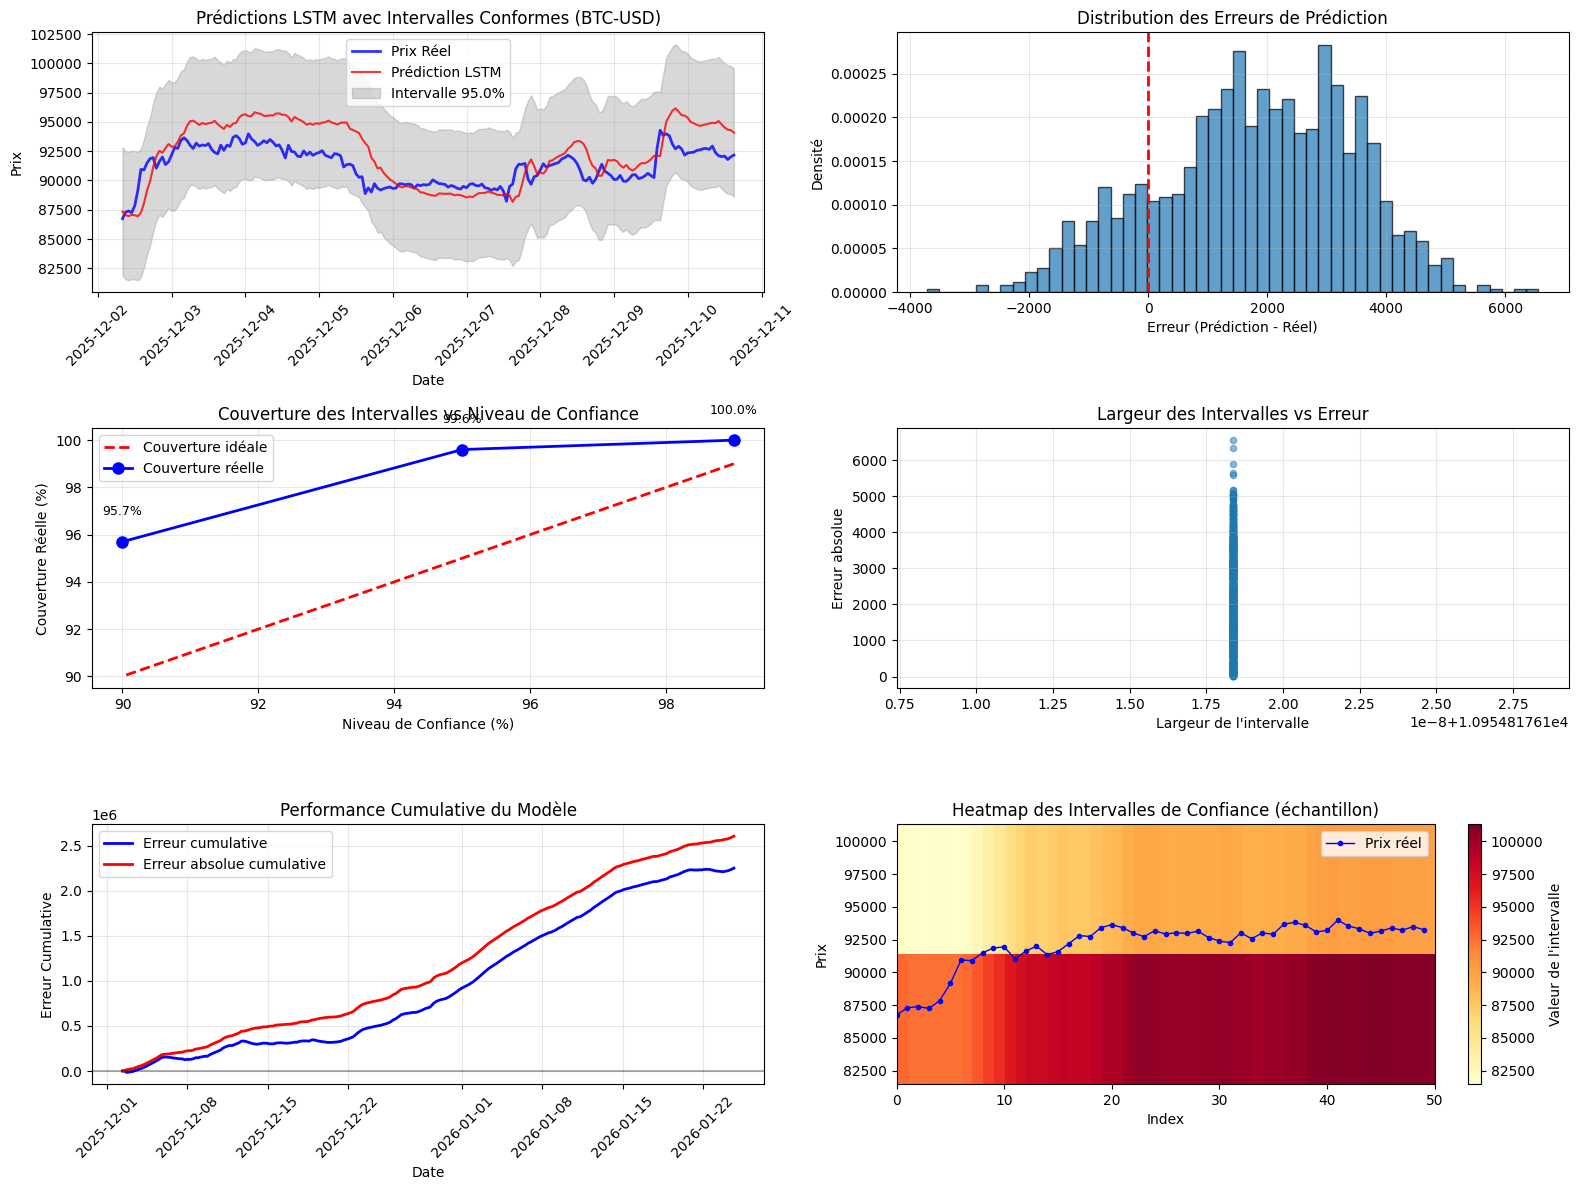

In [11]:
# ✅ Bloc 10 : Visualisation des Prédictions Conformes
# ============================================================
# Préparation des données pour le graphique
test_dates = df_features.index[-len(y_test_original):]
alpha_selected = 0.05  # Correction: Utilisation de 0.05 pour correspondre aux résultats disponibles
point_preds = results[alpha_selected]['point_preds']
intervals = results[alpha_selected]['intervals']
y_test_original = scaler_y.inverse_transform(y_test).flatten()

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. Prédictions vs Réel (premières 200 observations)
axes[0, 0].plot(test_dates[:200], y_test_original[:200],
                label='Prix Réel', color='blue', linewidth=2, alpha=0.8)
axes[0, 0].plot(test_dates[:200], point_preds[:200],
                label='Prédiction LSTM', color='red', linewidth=1.5, alpha=0.8)
axes[0, 0].fill_between(test_dates[:200],
                        intervals[:200, 0],
                        intervals[:200, 1],
                        color='gray', alpha=0.3,
                        label=f'Intervalle {100*(1-alpha_selected)}%')
axes[0, 0].set_title(f'Prédictions LSTM avec Intervalles Conformes ({SYMBOL})')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Prix')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Distribution des erreurs
axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7, density=True)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_title('Distribution des Erreurs de Prédiction')
axes[0, 1].set_xlabel('Erreur (Prédiction - Réel)')
axes[0, 1].set_ylabel('Densité')
axes[0, 1].grid(True, alpha=0.3)

# 3. Couverture vs Niveau de confiance
conf_levels = [100*(1-alpha) for alpha in significance_levels]
coverages = [results[alpha]['coverage'] * 100 for alpha in significance_levels]

axes[1, 0].plot(conf_levels, conf_levels, 'r--', label='Couverture idéale', linewidth=2)
axes[1, 0].plot(conf_levels, coverages, 'bo-', label='Couverture réelle', linewidth=2, markersize=8)
for i, (conf, cov) in enumerate(zip(conf_levels, coverages)):
    axes[1, 0].text(conf, cov+1, f'{cov:.1f}%', ha='center', va='bottom', fontsize=9)
axes[1, 0].set_title('Couverture des Intervalles vs Niveau de Confiance')
axes[1, 0].set_xlabel('Niveau de Confiance (%)')
axes[1, 0].set_ylabel('Couverture Réelle (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Largeur des intervalles vs erreur
interval_widths = intervals[:, 1] - intervals[:, 0]
abs_errors = np.abs(errors)

axes[1, 1].scatter(interval_widths, abs_errors, alpha=0.5, s=20)
axes[1, 1].set_xlabel('Largeur de l\'intervalle')
axes[1, 1].set_ylabel('Erreur absolue')
axes[1, 1].set_title('Largeur des Intervalles vs Erreur')
axes[1, 1].grid(True, alpha=0.3)

# 5. Performance cumulative
cumulative_error = np.cumsum(errors)
cumulative_abs_error = np.cumsum(np.abs(errors))

axes[2, 0].plot(test_dates, cumulative_error, label='Erreur cumulative', color='blue', linewidth=2)
axes[2, 0].plot(test_dates, cumulative_abs_error, label='Erreur absolue cumulative', color='red', linewidth=2)
axes[2, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[2, 0].set_title('Performance Cumulative du Modèle')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Erreur Cumulative')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].tick_params(axis='x', rotation=45)

# 6. Heatmap des intervalles (échantillon)
sample_size = 50
interval_sample = intervals[:sample_size]
y_sample = y_test_original[:sample_size]

im = axes[2, 1].imshow(interval_sample.T, aspect='auto', cmap='YlOrRd',
                       extent=[0, sample_size, interval_sample.min(), interval_sample.max()])
axes[2, 1].plot(range(sample_size), y_sample, 'bo-', label='Prix réel', markersize=3, linewidth=1)
axes[2, 1].set_title('Heatmap des Intervalles de Confiance (échantillon)')
axes[2, 1].set_xlabel('Index')
axes[2, 1].set_ylabel('Prix')
axes[2, 1].legend(loc='upper right')
plt.colorbar(im, ax=axes[2, 1], label='Valeur de l\'intervalle')

plt.tight_layout()
plt.show()

In [12]:
# ✅ Bloc 11 : Système de Trading Simulé
# ============================================================
class VirtualTradingSystem:
    """
    Système de trading virtuel avec LSTM + Conformal Prediction
    """

    def __init__(self, lstm_model, scaler_y, icp, feature_cols, sequence_length,
                 initial_capital=10000, transaction_cost=0.001):
        self.model = lstm_model
        self.scaler_y = scaler_y
        self.icp = icp
        self.feature_cols = feature_cols
        self.sequence_length = sequence_length
        self.capital = initial_capital
        self.transaction_cost = transaction_cost
        self.portfolio = {'cash': initial_capital, 'shares': 0, 'value': initial_capital}
        self.trade_history = []
        self.position = 0  # 0: neutre, 1: long, -1: short

    def prepare_input(self, df):
        """Prépare les données pour la prédiction"""
        # Prendre les dernières séquences
        if len(df) < self.sequence_length:
            raise ValueError(f"Données insuffisantes. Nécessite {self.sequence_length} périodes, a {len(df)}")

        recent_data = df.iloc[-self.sequence_length:][self.feature_cols].copy()

        # Normalisation
        features_array = recent_data.values

        return features_array.reshape(1, self.sequence_length, len(self.feature_cols))

    def generate_signal(self, df, current_price, confidence_level=0.9):
        """Génère un signal de trading"""
        try:
            X_input = self.prepare_input(df)

            # Prédiction ponctuelle
            pred_scaled = self.model.predict(X_input, verbose=0)[0][0]
            pred_price = self.scaler_y.inverse_transform([[pred_scaled]])[0][0]

            # Intervalle de confiance
            X_flat = X_input.reshape(1, -1)
            interval = self.icp.predict(X_flat, significance=1-confidence_level)[0]

            # Calcul des probabilités directionnelles
            expected_return = (pred_price - current_price) / current_price

            # Décision basée sur l'intervalle de confiance
            if pred_price > interval[1] * 1.02:  # Fortement au-dessus de l'intervalle supérieur
                signal = "STRONG_BUY"
                confidence_score = 0.9
            elif pred_price > current_price * 1.01 and pred_price > interval[1]:
                signal = "BUY"
                confidence_score = 0.7
            elif pred_price < interval[0] * 0.98:  # Fortement en-dessous de l'intervalle inférieur
                signal = "STRONG_SELL"
                confidence_score = 0.9
            elif pred_price < current_price * 0.99 and pred_price < interval[0]:
                signal = "SELL"
                confidence_score = 0.7
            else:
                signal = "HOLD"
                confidence_score = 0.3

            return {
                'signal': signal,
                'confidence': confidence_score,
                'pred_price': pred_price,
                'current_price': current_price,
                'interval_low': interval[0],
                'interval_high': interval[1],
                'expected_return': expected_return,
                'interval_width': interval[1] - interval[0],
                'interval_width_pct': (interval[1] - interval[0]) / current_price * 100
            }

        except Exception as e:
            print(f"❌ Erreur dans generate_signal: {e}")
            return {
                'signal': 'HOLD',
                'confidence': 0,
                'pred_price': current_price,
                'current_price': current_price,
                'interval_low': current_price * 0.95,
                'interval_high': current_price * 1.05,
                'expected_return': 0,
                'interval_width': current_price * 0.1,
                'interval_width_pct': 10
            }

    def calculate_position_size(self, signal_info, risk_per_trade=0.02):
        """Calcule la taille de position optimale"""
        if signal_info['signal'] == 'HOLD':
            return 0

        # Capital risqué
        risk_capital = self.capital * risk_per_trade

        # Ajustement selon la confiance
        confidence_multiplier = signal_info['confidence']

        # Volatilité ajustée (basée sur la largeur de l'intervalle)
        volatility_adj = max(0.01, signal_info['interval_width_pct'] / 100)

        # Calcul de la taille
        position_value = risk_capital * confidence_multiplier / volatility_adj
        position_size = position_value / signal_info['current_price']

        return position_size

    def execute_trade(self, signal_info, df):
        """Exécute un trade virtuel"""
        current_price = signal_info['current_price']
        signal = signal_info['signal']
        confidence = signal_info['confidence']

        # Calcul de la taille de position
        position_size = self.calculate_position_size(signal_info)

        if position_size <= 0 or signal == 'HOLD':
            return {'action': 'HOLD', 'size': 0, 'price': current_price}

        # Frais de transaction
        transaction_cost_amount = position_size * current_price * self.transaction_cost

        if 'BUY' in signal and self.position <= 0:
            # Achat
            cost = position_size * current_price + transaction_cost_amount

            if cost <= self.portfolio['cash']:
                self.portfolio['cash'] -= cost
                self.portfolio['shares'] += position_size
                self.position = 1

                trade_record = {
                    'timestamp': df.index[-1],
                    'action': 'BUY',
                    'size': position_size,
                    'price': current_price,
                    'cost': cost,
                    'confidence': confidence,
                    'portfolio_value': self.get_portfolio_value(current_price)
                }
                self.trade_history.append(trade_record)

                return trade_record

        elif 'SELL' in signal and self.position >= 0:
            # Vente (si on a des actions)
            if self.portfolio['shares'] > 0:
                revenue = position_size * current_price - transaction_cost_amount
                self.portfolio['cash'] += revenue
                self.portfolio['shares'] -= position_size
                self.position = -1 if 'STRONG' in signal else 0

                trade_record = {
                    'timestamp': df.index[-1],
                    'action': 'SELL',
                    'size': position_size,
                    'price': current_price,
                    'revenue': revenue,
                    'confidence': confidence,
                    'portfolio_value': self.get_portfolio_value(current_price)
                }
                self.trade_history.append(trade_record)

                return trade_record

        return {'action': 'HOLD', 'size': 0, 'price': current_price}

    def get_portfolio_value(self, current_price):
        """Calcule la valeur totale du portefeuille"""
        stock_value = self.portfolio['shares'] * current_price
        total_value = self.portfolio['cash'] + stock_value
        self.portfolio['value'] = total_value
        return total_value

    def run_backtest(self, df, start_idx=None, end_idx=None):
        """Exécute un backtest complet"""
        if start_idx is None:
            start_idx = sequence_length * 2
        if end_idx is None:
            end_idx = len(df)

        print(f"🚀 Démarrage du backtest sur {end_idx - start_idx} périodes...")

        portfolio_values = []
        signals_history = []

        for i in range(start_idx, end_idx):
            current_data = df.iloc[:i]
            current_price = df['close'].iloc[i-1]

            # Générer le signal
            signal_info = self.generate_signal(current_data, current_price)

            # Exécuter le trade
            trade_result = self.execute_trade(signal_info, current_data)

            # Mettre à jour la valeur du portefeuille
            portfolio_value = self.get_portfolio_value(current_price)
            portfolio_values.append(portfolio_value)

            # Enregistrer l'historique
            signals_history.append({
                'timestamp': df.index[i-1],
                'price': current_price,
                'signal': signal_info['signal'],
                'confidence': signal_info['confidence'],
                'pred_price': signal_info['pred_price'],
                'portfolio_value': portfolio_value,
                'trade_action': trade_result['action']
            })

        # Résultats finaux
        initial_value = portfolio_values[0]
        final_value = portfolio_values[-1]
        total_return = (final_value - initial_value) / initial_value * 100

        # Calcul des métriques de performance
        returns = np.diff(portfolio_values) / portfolio_values[:-1]
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 0 else 0
        max_drawdown = self.calculate_max_drawdown(portfolio_values)

        print(f"\n{'='*60}")
        print(f"📊 RÉSULTATS DU BACKTEST")
        print(f"{'='*60}")
        print(f"💰 Capital initial: ${initial_value:,.2f}")
        print(f"💰 Capital final: ${final_value:,.2f}")
        print(f"📈 Rendement total: {total_return:.2f}%")
        print(f"⭐ Ratio de Sharpe: {sharpe_ratio:.2f}")
        print(f"📉 Max Drawdown: {max_drawdown:.2f}%")
        print(f"🔁 Nombre de trades: {len(self.trade_history)}")
        print(f"{'='*60}")

        return pd.DataFrame(signals_history), portfolio_values

    def calculate_max_drawdown(self, values):
        """Calcule le maximum drawdown"""
        peak = values[0]
        max_dd = 0

        for value in values:
            if value > peak:
                peak = value
            dd = (peak - value) / peak * 100
            if dd > max_dd:
                max_dd = dd

        return max_dd


In [13]:
# ✅ Bloc 12 : Backtest Complet
# ============================================================
# Initialisation du système de trading
trading_system = VirtualTradingSystem(
    lstm_model=lstm_model,
    scaler_y=scaler_y,
    icp=icp,
    feature_cols=feature_cols,
    sequence_length=sequence_length,
    initial_capital=10000,
    transaction_cost=0.001
)

# Exécution du backtest
print("🎯 Lancement du backtest avec LSTM + Conformal Prediction...")
signals_df, portfolio_values = trading_system.run_backtest(
    df_features,
    start_idx=sequence_length * 2,
    end_idx=min(len(df_features), sequence_length * 2 + 500)  # Limité à 500 périodes pour la démo
)


🎯 Lancement du backtest avec LSTM + Conformal Prediction...
🚀 Démarrage du backtest sur 500 périodes...

📊 RÉSULTATS DU BACKTEST
💰 Capital initial: $10,000.00
💰 Capital final: $10,000.00
📈 Rendement total: 0.00%
⭐ Ratio de Sharpe: nan
📉 Max Drawdown: 0.00%
🔁 Nombre de trades: 0


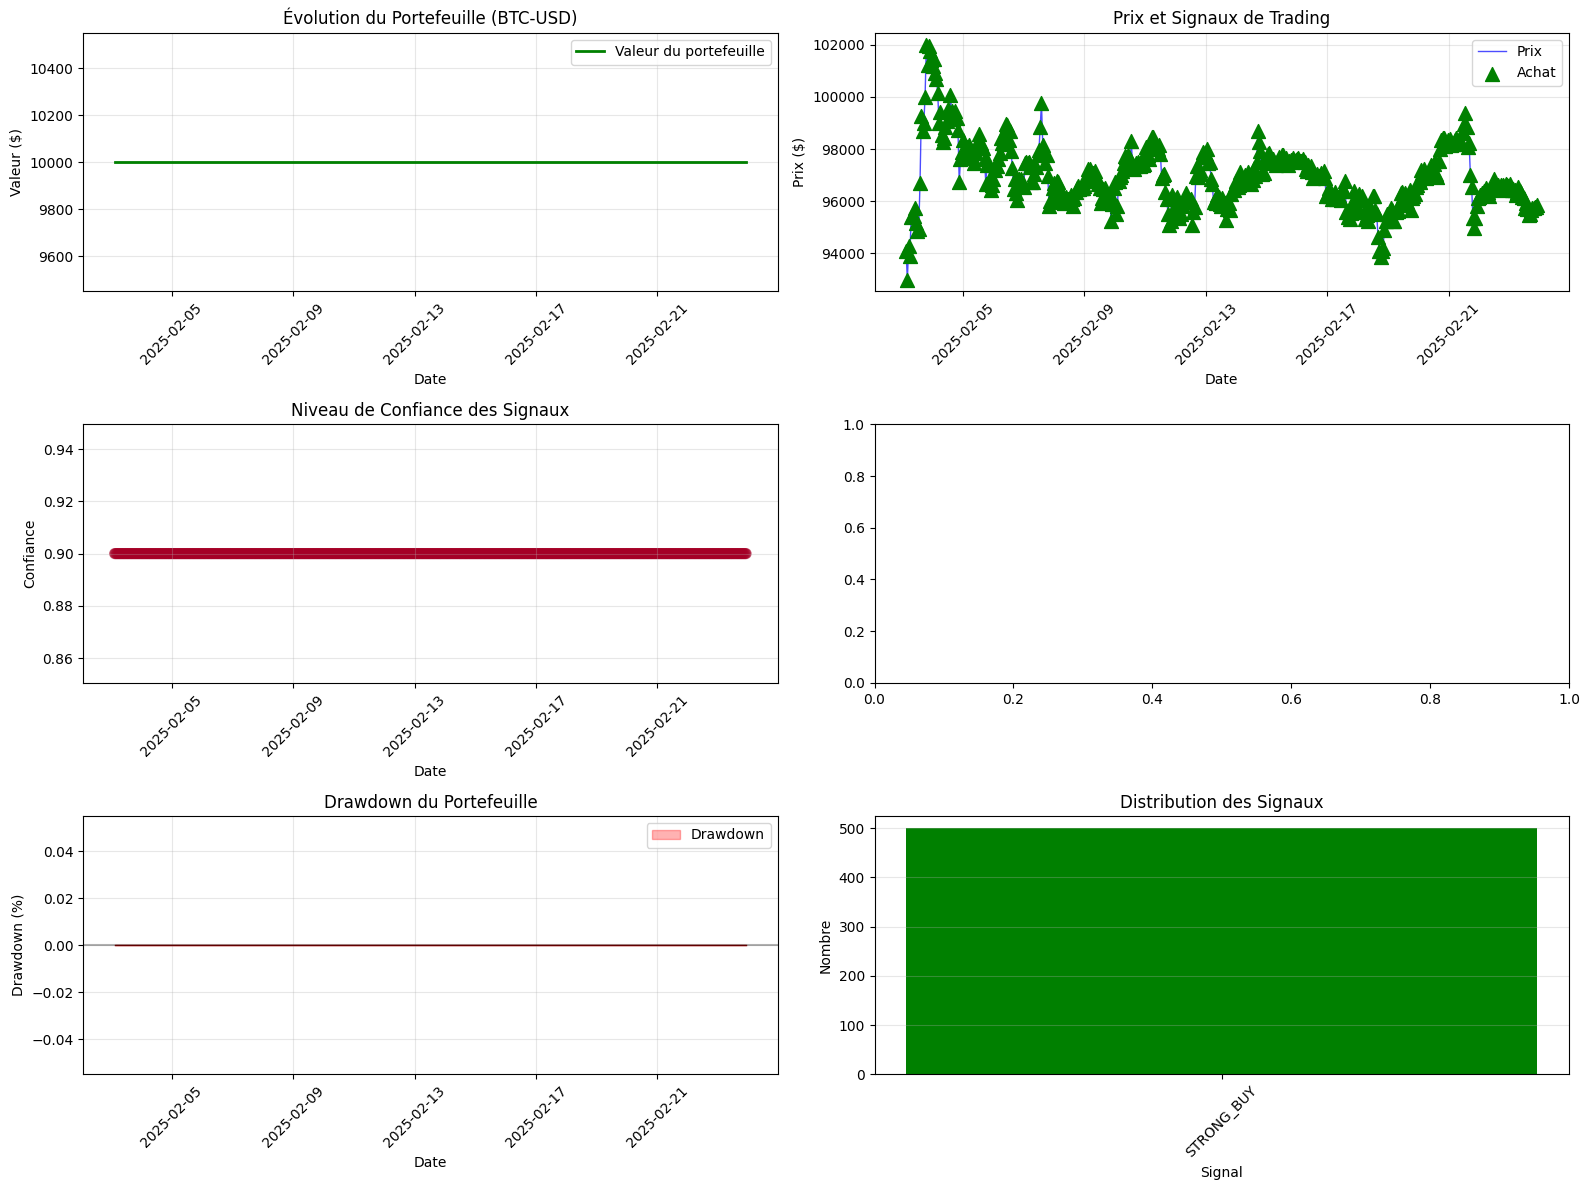

In [14]:
# ✅ Bloc 13 : Visualisation des Résultats du Trading
# ============================================================
if len(signals_df) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))

    # 1. Évolution du portefeuille
    axes[0, 0].plot(signals_df['timestamp'], portfolio_values,
                    label='Valeur du portefeuille', color='green', linewidth=2)
    axes[0, 0].fill_between(signals_df['timestamp'],
                           min(portfolio_values),
                           portfolio_values,
                           alpha=0.3, color='green')
    axes[0, 0].set_title(f'Évolution du Portefeuille ({SYMBOL})')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Valeur ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Prix et signaux
    axes[0, 1].plot(signals_df['timestamp'], signals_df['price'],
                    label='Prix', color='blue', alpha=0.7, linewidth=1)

    # Points d'achat
    buy_signals = signals_df[signals_df['signal'].str.contains('BUY')]
    if not buy_signals.empty:
        axes[0, 1].scatter(buy_signals['timestamp'], buy_signals['price'],
                          color='green', s=100, marker='^', label='Achat', zorder=5)

    # Points de vente
    sell_signals = signals_df[signals_df['signal'].str.contains('SELL')]
    if not sell_signals.empty:
        axes[0, 1].scatter(sell_signals['timestamp'], sell_signals['price'],
                          color='red', s=100, marker='v', label='Vente', zorder=5)

    axes[0, 1].set_title('Prix et Signaux de Trading')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Prix ($)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Confiance des signaux
    axes[1, 0].scatter(signals_df['timestamp'], signals_df['confidence'],
                      c=signals_df['confidence'], cmap='RdYlGn', alpha=0.6, s=50)
    axes[1, 0].set_title('Niveau de Confiance des Signaux')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Confiance')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Distribution des rendements
    if len(trading_system.trade_history) > 0:
        trades_df = pd.DataFrame(trading_system.trade_history)
        if 'profit' not in trades_df.columns and len(trades_df) >= 2:
            # Calcul simplifié des profits
            profits = []
            for i in range(1, len(trades_df), 2):
                if i < len(trades_df):
                    buy_trade = trades_df.iloc[i-1]
                    sell_trade = trades_df.iloc[i]
                    if buy_trade['action'] == 'BUY' and sell_trade['action'] == 'SELL':
                        profit = (sell_trade['price'] - buy_trade['price']) * buy_trade['size']
                        profits.append(profit)

            if profits:
                axes[1, 1].hist(profits, bins=20, edgecolor='black', alpha=0.7)
                axes[1, 1].axvline(x=np.mean(profits), color='r', linestyle='--',
                                  label=f'Moyenne: ${np.mean(profits):.2f}')
                axes[1, 1].set_title('Distribution des Profits par Trade')
                axes[1, 1].set_xlabel('Profit ($)')
                axes[1, 1].set_ylabel('Fréquence')
                axes[1, 1].legend()
                axes[1, 1].grid(True, alpha=0.3)

    # 5. Drawdown
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdown = (cumulative_max - portfolio_values) / cumulative_max * 100

    axes[2, 0].fill_between(signals_df['timestamp'], 0, drawdown,
                           color='red', alpha=0.3, label='Drawdown')
    axes[2, 0].plot(signals_df['timestamp'], drawdown, color='darkred', linewidth=1)
    axes[2, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[2, 0].set_title('Drawdown du Portefeuille')
    axes[2, 0].set_xlabel('Date')
    axes[2, 0].set_ylabel('Drawdown (%)')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].tick_params(axis='x', rotation=45)

    # 6. Fréquence des signaux
    if not signals_df.empty:
        signal_counts = signals_df['signal'].value_counts()
        axes[2, 1].bar(signal_counts.index, signal_counts.values,
                      color=['green' if 'BUY' in s else 'red' if 'SELL' in s else 'gray'
                            for s in signal_counts.index])
        axes[2, 1].set_title('Distribution des Signaux')
        axes[2, 1].set_xlabel('Signal')
        axes[2, 1].set_ylabel('Nombre')
        axes[2, 1].tick_params(axis='x', rotation=45)
        axes[2, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()


In [15]:
# ✅ Bloc 14 : Prédiction en Temps Réel (Simulé)
# ============================================================
def simulate_real_time_prediction(trading_system, df, n_predictions=10):
    """
    Simule des prédictions en temps réel
    """
    print(f"\n{'='*60}")
    print("🔮 SIMULATION DE PRÉDICTION EN TEMPS RÉEL")
    print(f"{'='*60}")

    predictions = []

    for i in range(n_predictions):
        # Prendre les données les plus récentes
        start_idx = len(df) - sequence_length - i - 1
        end_idx = len(df) - i

        if start_idx < 0:
            break

        current_data = df.iloc[start_idx:end_idx]
        current_price = df['close'].iloc[end_idx-1]

        # Générer la prédiction
        signal_info = trading_system.generate_signal(current_data, current_price, confidence_level=0.9)

        predictions.append(signal_info)

        print(f"\n⏰ Prédiction {i+1}/{n_predictions}")
        print(f"   📅 Date: {df.index[end_idx-1]}")
        print(f"   💰 Prix actuel: ${current_price:.2f}")
        print(f"   🎯 Prix prédit: ${signal_info['pred_price']:.2f}")
        print(f"   📊 Intervalle: [${signal_info['interval_low']:.2f}, ${signal_info['interval_high']:.2f}]")
        print(f"   📏 Largeur: {signal_info['interval_width_pct']:.2f}%")
        print(f"   🚦 Signal: {signal_info['signal']} (confiance: {signal_info['confidence']:.2f})")
        print(f"   📈 Rendement attendu: {signal_info['expected_return']*100:.2f}%")

        # Recommandation
        if signal_info['signal'] == 'STRONG_BUY':
            print("   ✅ RECOMMANDATION: ACHAT FORT")
        elif signal_info['signal'] == 'BUY':
            print("   👍 RECOMMANDATION: ACHAT")
        elif signal_info['signal'] == 'STRONG_SELL':
            print("   ⚠️ RECOMMANDATION: VENTE FORTE")
        elif signal_info['signal'] == 'SELL':
            print("   👎 RECOMMANDATION: VENTE")
        else:
            print("   ⏸️ RECOMMANDATION: NEUTRE/ATTENTE")

    return predictions

# Exécution de la simulation
latest_predictions = simulate_real_time_prediction(trading_system, df_features, n_predictions=5)



🔮 SIMULATION DE PRÉDICTION EN TEMPS RÉEL

⏰ Prédiction 1/5
   📅 Date: 2026-01-24 17:00:00+00:00
   💰 Prix actuel: $89246.38
   🎯 Prix prédit: $118354.77
   📊 Intervalle: [$1.05, $1.77]
   📏 Largeur: 0.00%
   🚦 Signal: STRONG_BUY (confiance: 0.90)
   📈 Rendement attendu: 32.62%
   ✅ RECOMMANDATION: ACHAT FORT

⏰ Prédiction 2/5
   📅 Date: 2026-01-24 16:00:00+00:00
   💰 Prix actuel: $89149.10
   🎯 Prix prédit: $118354.76
   📊 Intervalle: [$1.05, $1.77]
   📏 Largeur: 0.00%
   🚦 Signal: STRONG_BUY (confiance: 0.90)
   📈 Rendement attendu: 32.76%
   ✅ RECOMMANDATION: ACHAT FORT

⏰ Prédiction 3/5
   📅 Date: 2026-01-24 15:00:00+00:00
   💰 Prix actuel: $89143.55
   🎯 Prix prédit: $118354.73
   📊 Intervalle: [$1.05, $1.77]
   📏 Largeur: 0.00%
   🚦 Signal: STRONG_BUY (confiance: 0.90)
   📈 Rendement attendu: 32.77%
   ✅ RECOMMANDATION: ACHAT FORT

⏰ Prédiction 4/5
   📅 Date: 2026-01-24 14:00:00+00:00
   💰 Prix actuel: $89313.25
   🎯 Prix prédit: $118354.67
   📊 Intervalle: [$1.05, $1.77]
   📏 La

In [16]:
# ✅ Bloc 15 : Sauvegarde des Modèles et Résultats
# ============================================================
import joblib
import json
from datetime import datetime

# Création du dossier de sauvegarde
import os
os.makedirs('lstm_conformal_results', exist_ok=True)

# 1. Sauvegarde du modèle LSTM
lstm_model.save('lstm_conformal_results/lstm_model.h5')
print("💾 Modèle LSTM sauvegardé")

# 2. Sauvegarde des scalers
joblib.dump(scaler_X, 'lstm_conformal_results/scaler_X.pkl')
joblib.dump(scaler_y, 'lstm_conformal_results/scaler_y.pkl')
print("💾 Scalers sauvegardés")

# 3. Sauvegarde des features
feature_info = {
    'feature_cols': feature_cols,
    'sequence_length': sequence_length,
    'symbol': SYMBOL,
    'timestamp': datetime.now().isoformat()
}
with open('lstm_conformal_results/feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)
print("💾 Informations des features sauvegardées")

# 4. Sauvegarde des résultats
if len(signals_df) > 0:
    signals_df.to_csv('lstm_conformal_results/trading_signals.csv', index=False)
    print("💾 Signaux de trading sauvegardés")

# 5. Sauvegarde des métriques
metrics = {
    'mae': results[0.1]['mae'],
    'rmse': results[0.1]['rmse'],
    'coverage_90': results[0.1]['coverage'],
    'coverage_95': results[0.05]['coverage'],
    'coverage_99': results[0.01]['coverage'],
    'avg_interval_width': results[0.1]['avg_width_pct'],
    'n_trades': len(trading_system.trade_history) if hasattr(trading_system, 'trade_history') else 0,
    'final_portfolio_value': portfolio_values[-1] if 'portfolio_values' in locals() else 0
}
with open('lstm_conformal_results/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("💾 Métriques sauvegardées")

# 6. Rapport final
print(f"\n{'='*60}")
print("📊 RAPPORT FINAL DU SYSTÈME LSTM + CONFORMAL PREDICTION")
print(f"{'='*60}")
print(f"Symbole: {SYMBOL}")
print(f"Période: {df.index[0].date()} au {df.index[-1].date()}")
print(f"Nombre total de périodes: {len(df)}")
print(f"Taille des séquences: {sequence_length}")
print(f"Nombre de features: {len(feature_cols)}")
print(f"\n📈 Performance du Modèle:")
print(f"   MAE: {metrics['mae']:.4f}")
print(f"   RMSE: {metrics['rmse']:.4f}")
print(f"   Couverture à 90%: {metrics['coverage_90']:.2%}")
print(f"   Couverture à 95%: {metrics['coverage_95']:.2%}")
print(f"   Largeur moyenne des intervalles: {metrics['avg_interval_width']:.2f}%")
print(f"\n💼 Performance du Trading:")
if 'portfolio_values' in locals() and len(portfolio_values) > 0:
    initial = portfolio_values[0]
    final = portfolio_values[-1]
    return_pct = (final - initial) / initial * 100
    print(f"   Valeur initiale: ${initial:,.2f}")
    print(f"   Valeur finale: ${final:,.2f}")
    print(f"   Rendement: {return_pct:.2f}%")
    print(f"   Nombre de trades: {metrics['n_trades']}")
print(f"\n💾 Fichiers sauvegardés dans: lstm_conformal_results/")
print(f"{'='*60}")

# Téléchargement des résultats (pour Colab)
from google.colab import files

# Création d'une archive
!zip -r lstm_conformal_results.zip lstm_conformal_results/

print("\n📥 Pour télécharger les résultats, exécutez:")
print("files.download('lstm_conformal_results.zip')")

💾 Modèle LSTM sauvegardé
💾 Scalers sauvegardés
💾 Informations des features sauvegardées
💾 Signaux de trading sauvegardés
💾 Métriques sauvegardées

📊 RAPPORT FINAL DU SYSTÈME LSTM + CONFORMAL PREDICTION
Symbole: BTC-USD
Période: 2025-01-25 au 2026-01-25
Nombre total de périodes: 8603
Taille des séquences: 60
Nombre de features: 80

📈 Performance du Modèle:
   MAE: 2073.4672
   RMSE: 2428.0312
   Couverture à 90%: 95.70%
   Couverture à 95%: 99.60%
   Largeur moyenne des intervalles: 9.62%

💼 Performance du Trading:
   Valeur initiale: $10,000.00
   Valeur finale: $10,000.00
   Rendement: 0.00%
   Nombre de trades: 0

💾 Fichiers sauvegardés dans: lstm_conformal_results/
  adding: lstm_conformal_results/ (stored 0%)
  adding: lstm_conformal_results/feature_info.json (deflated 68%)
  adding: lstm_conformal_results/metrics.json (deflated 34%)
  adding: lstm_conformal_results/trading_signals.csv (deflated 79%)
  adding: lstm_conformal_results/lstm_model.h5 (deflated 7%)
  adding: lstm_confor